# Time Series Exercise - 

### Follow along with the instructions in bold. Watch the solutions video if you get stuck!

## The Data

** Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line **

**Monthly milk production: pounds per cow. Jan 62 - Dec 75**

** Import numpy pandas and matplotlib **

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


** Use pandas to read the csv of the monthly-milk-production.csv file and set index_col='Month' **

In [11]:
milk = pd.read_csv('monthly-milk-production.csv')
milk = milk.set_index('Month')
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


** Check out the head of the dataframe**

In [12]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


** Make the index a time series by using: **

    milk.index = pd.to_datetime(milk.index)

In [13]:
milk.index = pd.to_datetime(milk.index)

** Plot out the time series data. **

<AxesSubplot:xlabel='Month'>

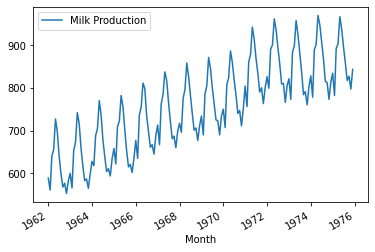

In [14]:
milk.plot()

___

### Train Test Split

** Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) **

** Create a test train split using indexing (hint: use .head() or tail() or .iloc[]). We don't want a random train test split, we want to specify that the test set is the last 12 months of data is the test set, with everything before it is the training. **

In [15]:
from sklearn.model_selection import train_test_split


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [16]:
train_set = milk.head(156) #12 months
test_set = milk.tail(12)

### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!**

In [17]:
from sklearn.preprocessing import MinMaxScaler


In [18]:
scaler = MinMaxScaler()

In [19]:
train_scaled = scaler.fit_transform(train_set)

In [20]:
test_scaled = scaler.transform(test_set)

## Batch Function

** We'll need a function that can feed batches of the training data. We'll need to do several things that are listed out as steps in the comments of the function. Remember to reference the previous batch method from the lecture for hints. Try to fill out the function template below, this is a pretty hard step, so feel free to reference the solutions! **

In [21]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    rand_start = np.random.randint(0,len(training_data)-steps)
    
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps + 1. Then reshape this data to be (1,steps+1)
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN to .reshape(-1,steps,1)
    return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

## Setting Up The RNN Model

** Import TensorFlow **

In [22]:
import tensorflow as tf

### The Constants

** Define the constants in a single cell. You'll need the following (in parenthesis are the values I used in my solution, but you can play with some of these): **
* Number of Inputs (1)
* Number of Time Steps (12)
* Number of Neurons per Layer (100)
* Number of Outputs (1)
* Learning Rate (0.03)
* Number of Iterations for Training (4000)
* Batch Size (1)

In [23]:
num_inputs = 1
num_time_steps = 12
num_neurons = 100
num_outputs = 1
learning_rate = 0.03
num_train_iterations = 4000
batch_size = 1

** Create Placeholders for X and y. (You can change the variable names if you want). The shape for these placeholders should be [None,num_time_steps-1,num_inputs] and [None, num_time_steps-1, num_outputs] The reason we use num_time_steps-1 is because each of these will be one step shorter than the original time steps size, because we are training the RNN network to predict one point into the future based on the input sequence.**  

In [24]:
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

** Now create the RNN Layer, you have complete freedom over this, use tf.contrib.rnn and choose anything you want, OutputProjectionWrappers, BasicRNNCells, BasicLSTMCells, MultiRNNCell, GRUCell etc... Keep in mind not every combination will work well! (If in doubt, the solutions used an Outputprojection Wrapper around a basic LSTM cell with relu activation.**

In [27]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons,activation=tf.nn.relu), output_size=num_outputs)

** Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)**

In [28]:
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, remember to pass in your learning rate. **

In [29]:
loss = tf.reduce_mean(tf.square(outputs-y))


** Initialize the global variables **

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Create an instance of tf.train.Saver() **

In [32]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Session

** Run a tf.Session that trains on the batches created by your next_batch function. Also add an a loss evaluation for every 100 training iterations. Remember to save your model after you are done training. **

In [34]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [35]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    # CODE HERE!
    sess.run(init)
    for iteration in range(num_train_iterations):
        X_batch, y_batch = next_batch(train_scaled, batch_size, num_time_steps)
        sess.run(train, feed_dict= {X: X_batch, y:y_batch})
        
        if iteration % 100 == 0:
            mse= loss.eval(feed_dict={X:X_batch, y:y_batch})
            print(iteration, '\tMSE',mse)
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE 0.1721973
100 	MSE 0.04137249
200 	MSE 0.00812775
300 	MSE 0.012617058
400 	MSE 0.014078259
500 	MSE 0.010026225
600 	MSE 0.007716622
700 	MSE 0.010472685
800 	MSE 0.007483421
900 	MSE 0.009052525
1000 	MSE 0.011732615
1100 	MSE 0.0064757788
1200 	MSE 0.005676778
1300 	MSE 0.008421638
1400 	MSE 0.016030176
1500 	MSE 0.005938322
1600 	MSE 0.008354692
1700 	MSE 0.0080691865
1800 	MSE 0.0074598636
1900 	MSE 0.0042903502
2000 	MSE 0.011577473
2100 	MSE 0.0072886124
2200 	MSE 0.011888385
2300 	MSE 0.004230768
2400 	MSE 0.0049396073
2500 	MSE 0.013292701
2600 	MSE 0.006850214
2700 	MSE 0.0068675163
2800 	MSE 0.0077700317
2900 	MSE 0.0044578
3000 	MSE 0.005765188
3100 	MSE 0.0041443068
3200 	MSE 0.008615526
3300 	MSE 0.0047640842
3400 	MSE 0.0072625387
3500 	MSE 0.005047063
3600 	MSE 0.0062835556
3700 	MSE 0.008713623
3800 	MSE 0.006444268
3900 	MSE 0.007002475


______

## Predicting Future (Test Data)

** Show the test_set (the last 12 months of your original complete data set) **

In [ ]:
# CODE HERE

** Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our generated 12 months to our actual true historical values from the test set! **

# Generative Session
### NOTE: Recall that our model is really only trained to predict 1 time step ahead, asking it to generate 12 steps is a big ask, and technically not what it was trained to do! Think of this more as generating new values based off some previous pattern, rather than trying to directly predict the future. You would need to go back to the original model and train the model to predict 12 time steps ahead to really get a higher accuracy on the test data. (Which has its limits due to the smaller size of our data set)
** Fill out the session code below to generate 12 months of data based off the last 12 months of data from the training set. The hardest part about this is adjusting the arrays with their shapes and sizes. Reference the lecture for hints.**

In [36]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")
    train_seed = list(train_scaled[-12:])
    for iteration in range(12):
        X_batch =np.array(train_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        train_seed.append(y_pred[0,-1,0])

    # CODE HERE!

INFO:tensorflow:Restoring parameters from ./ex_time_series_model


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


** Show the result of the predictions. **

In [37]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.5760796,
 0.6090988,
 0.6300174,
 0.65212715,
 0.6686255,
 0.6832267,
 0.6783821,
 0.67163956,
 0.65426934,
 0.63586783,
 0.62002975,
 0.60391426]

** Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.**

In [38]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

** Create a new column on the test_set called "Generated" and set it equal to the generated results. You may get a warning about this, feel free to ignore it.**

In [39]:
test_set['Generated'] = results

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


** View the test_set dataframe. **

In [40]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,792.649109
1975-02-01 01:00:00,782.0,806.385071
1975-03-01 01:00:00,892.0,815.087219
1975-04-01 01:00:00,903.0,824.284851
1975-05-01 01:00:00,966.0,831.148193
1975-06-01 01:00:00,937.0,837.222351
1975-07-01 01:00:00,896.0,835.206970
1975-08-01 01:00:00,858.0,832.402100
1975-09-01 01:00:00,817.0,825.176025


** Plot out the two columns for comparison. **

<AxesSubplot:xlabel='Month'>

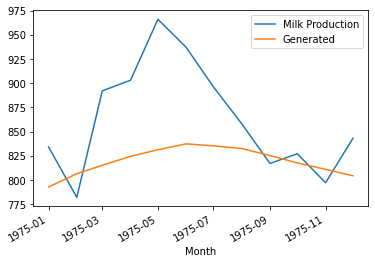

In [41]:
test_set.plot()

# Great Job!

Play around with the parameters and RNN layers, does a faster learning rate with more steps improve the model? What about GRU or BasicRNN units? What if you train the original model to not just predict one timestep ahead into the future, but 3 instead? Lots of stuff to add on here!